<a href="https://colab.research.google.com/github/al34n1x/DataScience/blob/master/8.Machine_Learning/descriptores/4.descriptores_textura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descriptores de textura

La matriz de coocurrencias mide la frecuencia en la que un píxel con nivel de intensidad `i` es adyacente de un píxel con nivel de intensidad `j`. La adyacencia se define a través de un número de píxeles vecinos `d` y una orientación (ángulo, `𝜶`). A partir de estos valores, es posible extraer diferentes características como: el contraste, la correlación, la disimilitud, la homogeneidad, la energía y la segundo momento angular. 

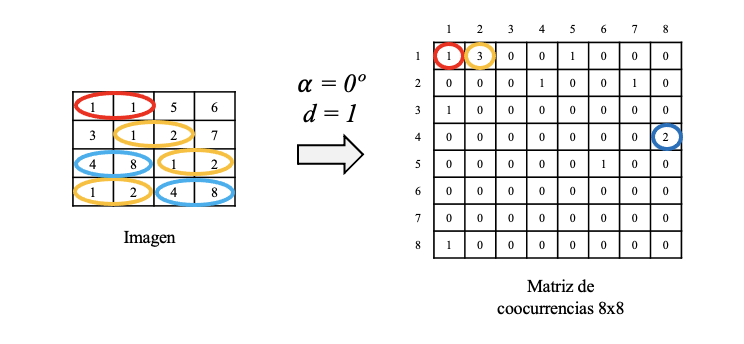


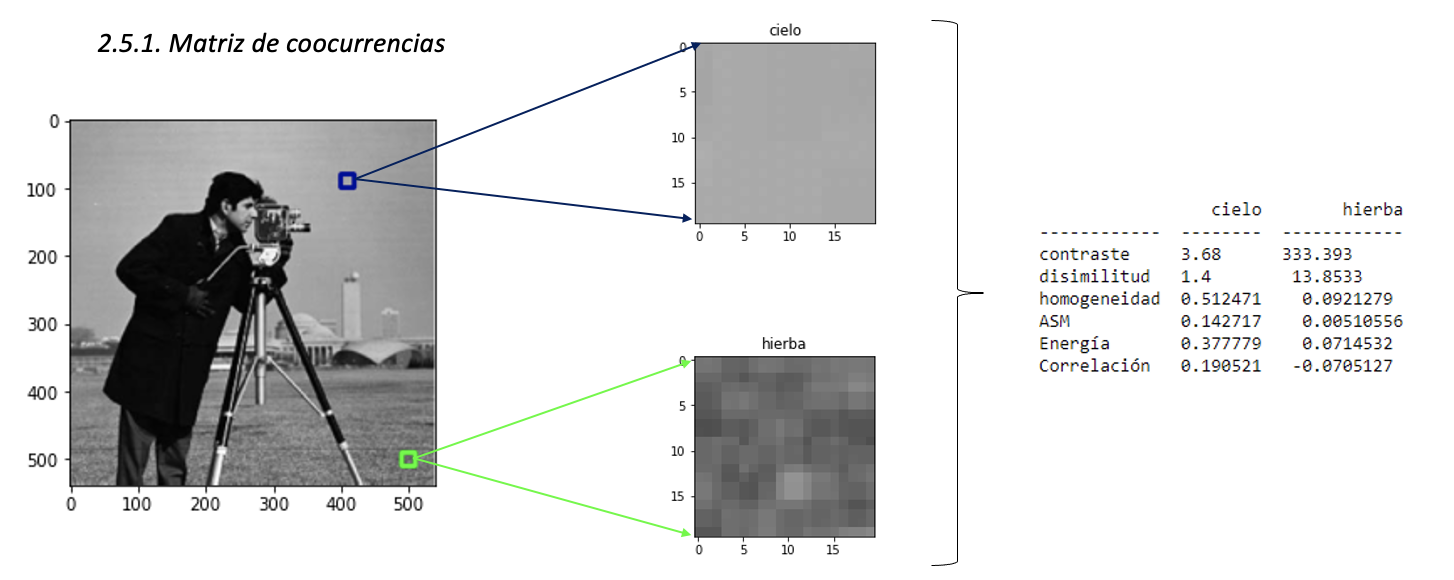

In [ ]:
# En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu
import matplotlib.pyplot as plt
import cv2
import numpy as np
img = cv2.imread('images/photographer.png')

window = cv2.rectangle(img.copy(), (400,80), (420,100), (0, 0, 255), 5)
window = cv2.rectangle(window, (490,490), (510,510), (0, 255, 0), 5)
plt.imshow(window, cmap='gray')
plt.show()

In [ ]:
# Seleccionamos una región del cielo y una de la hierba
cielo = img[80:100, 400:420]
hierba = img[490:510, 490:510]

fig, ax = plt.subplots(1,2)
ax[0].imshow(cielo, cmap='gray')
ax[0].set_title('cielo')
ax[1].imshow(hierba, cmap='gray')
ax[1].set_title('hierba')
plt.show()

### MATRIZ DE COOCURRENCIA

In [ ]:
# MATRIZ DE COOCURRENCIA (Gray-Level Cooccurence Matrix - GLCM)
from tabulate import tabulate
from skimage.feature import greycomatrix, greycoprops
headers = ['','cielo', 'hierba']
CN, DIS, H, ASM, E, COR = ['contraste'], ['disimilitud'], ['homogeneidad'], ['ASM'], ['Energía'], ['Correlación']

patches = []
patches.append(cielo)
patches.append(hierba)

for i in range(len(patches)):
    image = cv2.cvtColor(patches[i], cv2.COLOR_BGR2GRAY)
    GLCM = greycomatrix(image, distances=[5], angles=[0], levels=np.max(image)+1, symmetric=True, normed=True) #la distance es la cantidad de pixeles adyacentes que quiero analizar
    plt.imshow(GLCM[:,:,0,0], cmap='gray')
    plt.show()
    CN.append(greycoprops(GLCM, 'contrast')[0,0])
    DIS.append(greycoprops(GLCM, 'dissimilarity')[0,0])
    H.append(greycoprops(GLCM, 'homogeneity')[0,0])
    ASM.append(greycoprops(GLCM, 'ASM')[0,0])
    E.append(greycoprops(GLCM, 'energy')[0,0])
    COR.append(greycoprops(GLCM, 'correlation')[0,0])

my_data = [tuple(CN), tuple(DIS), tuple(H), tuple(ASM), tuple(E), tuple(COR)]

print(tabulate(my_data, headers=headers))

### Scale-Invariant Feature Transform (SIFT)

El algoritmo SIFT se utiliza en aplicaciones que involucran un escalado de la imagen. Sirve para la detección de esquinas, bordes o texturas, siendo estable frente a perturbaciones y transformaciones que pueda sufrir la imagen. Es invariante a posición, escala, rotación, iluminación y contraste.
Implementa una matriz con los punto de interés, a los cuales les cálcula la dirección y magnitud del gradiente, para luego, implementar un histograma de 36 bins adonde asigna cada uno de esos puntos de esos interés de acuerdo al bin correspondiente a la dirección del gradiente.

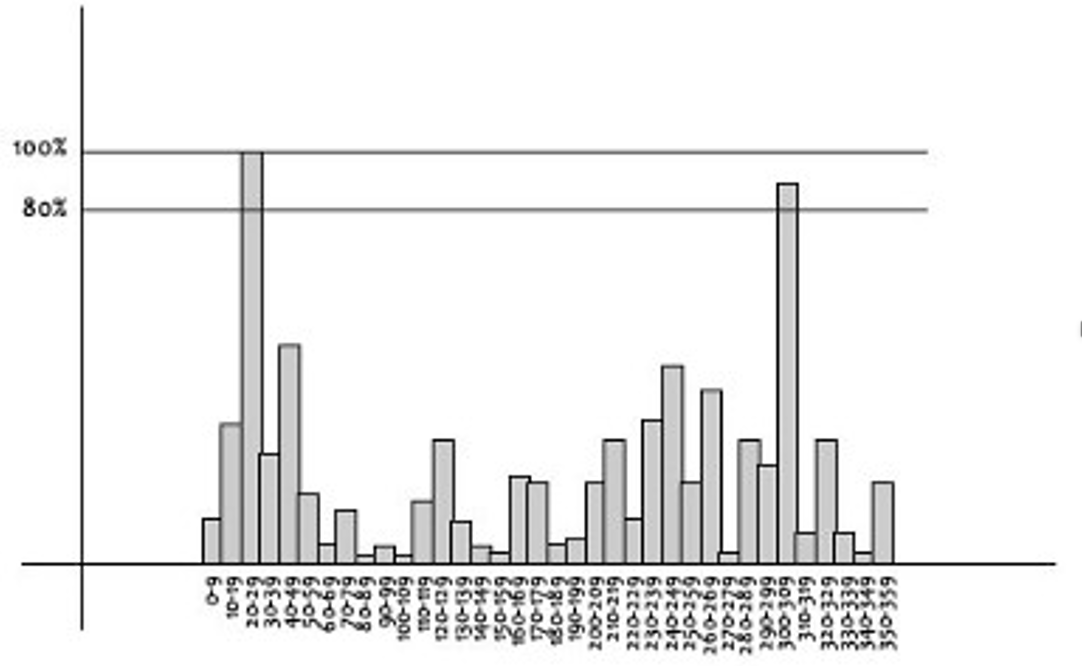

In [ ]:
# SIFT algorithm
img = cv2.imread('images/photographer.png')

# Definición del algoritmo
sift = cv2.SIFT_create()

# Identificamos los puntos de interés
kp = sift.detect(img, None)

# Extraemos el descriptor para obtener el fingreprint
kp, des = sift.compute(img, kp)
print(np.shape(des)) # Me imprime la cantidad de puntos de interes por la cantidad de histogramas por los bins (en este caso 128)
# print(des) # Matriz donde las filas son los keypoints y las columnas las características de dichos puntos clave

# Visualizamos los puntos de interés
img=cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

#Cada uno de esas 1672 instancias tienen 128 características (1672,128)

In [ ]:
# Puntos de interes para la imagen rotada
new_img = cv2.imread('images/photographer.png')
rows, cols, ch = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),angle=45,scale=1) # Defino la matriz de transformación
new_img = cv2.warpAffine(new_img,M,(cols,rows)) # Aplico la transformación

# Definición del algoritmo
sift = cv2.SIFT_create()

# Identificamos los puntos de interés
kp_rot = sift.detect(new_img, None)

# Extraemos el descriptor para obtener el fingreprint
kp_rot, des_rot = sift.compute(new_img, kp_rot)
print(np.shape(des_rot)) # Me imprime la cantidad de puntos de interes por la cantidad de histogramas por los bins (en este caso 128)
# print(des) # Matriz donde las filas son los keypoints y las columnas las características de dichos puntos clave

# Visualizamos los puntos de interés
new_img=cv2.drawKeypoints(new_img, kp_rot, new_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(new_img)
plt.show()

In [ ]:
# feature matching
from skimage import io
bf = cv2.BFMatcher.create ( cv2.NORM_L1 ,crossCheck = True )
matches = bf.match (des , des_rot )
matches = sorted ( matches , key = lambda x : x.distance )
print ( np.shape ( matches ) )
img_match = cv2.drawMatches ( img , kp , new_img , kp_rot , matches [ : 10 ] , new_img , flags = 10 )
plt.imshow ( img_match )
plt.show ( )

"""
Podemos observar como se han encontrado 968 punto de interés comunes entre ambas imágenes
"""

### Histogram of Oriented Gradients
El histograma de gradientes utiliza la distribución de la dirección de los gradientes como características, ya que la magnitud del gradiente presenta una alta respuesta a los cambios de intensidad elevados. Esto permite obtener información sobre la forma de los objetos. 
 

In [ ]:
# HISTOGRAM OF ORIENTED GRADIENTS

# En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu
from skimage import io
img = io.imread('images/pedestrian.jpg')
img = np.float32(img/255)
crop = img[75:550,475:700]
crop = cv2.resize(crop, (64, 128))

plt.imshow(crop, cmap='gray')
plt.show()

In [ ]:
# Calculamos el gradiente con el kernel de Sobel
crop = np.float32(crop)
gx = cv2.Sobel(crop, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(crop, cv2.CV_32F, 0, 1, ksize=1)

# Calculamos la magnitud y la dirección del gradiente
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

# Visualizamos la imagen obtenida en la magnitud del gradiente
mag = mag/np.max(mag)
plt.imshow(mag, cmap='gray')
plt.show()

In [ ]:
# Cálculo del desriptor: Histogram of Oriented Gradients
from skimage.feature import hog
H = hog(crop, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1") #channel_axis=2 es solicitado por las nuevas librerías
np.shape(H)

#Obtengo 3780 características de la imagen

### Local Binary Patterns

Los Local Binary Patterns (LBP) consisten en un operador que describe patrones de la imagen a nivel local proporcionando buenos resultados en aplicaciones de reconocimiento de texturas y en identificación de objetos y formas. El algoritmo para extraer los LBP consiste en un protocolo de ventana deslizante donde el valor del píxel central se modifica a partir del valor de intensidad de sus píxeles vecinos.

- Paso 1. Se calcula la diferencia de intensidad entre los píxeles vecinos y el píxel central.
- Paso 2. Se construye una matriz auxiliar a partir de la umbralización de las diferencias con 0s en los valores negativos y 1s en los positivos. 
- Paso 3. La matriz construida da lugar a una cadena binaria que se multiplica por una matriz de referencia.
- Paso 4. Se suman todos los valores que resultan de la multiplicación anterior y se establece el valor del píxel central. 


In [ ]:
# LOCAL BINARY PATTERNS (LBP)
from skimage.feature import local_binary_pattern
img = cv2.imread('images/photographer.png')

# Definimos los parámetros iniciales
R = 1 # Radio
P = 8*R # Número de píxeles vecinos
epsilon = 1e-7 # Para normalizar el histograma

# Extraemos la imagen LBP
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lbp_image = local_binary_pattern(img_gray, P, R, method='uniform') #Método uniforme, el más utilizado
a,b = np.unique(lbp_image, return_counts=True)

# Calculamos el histograma
lbp_image = np.uint8(lbp_image)
hist = cv2.calcHist([lbp_image.ravel()], [0], None, [P+2], [0, P+2])

# Normalizamos el histograma
hist = hist.astype("float")
hist /= (hist.sum() + epsilon)

# Los P+2=10 bins del histograma serán los 10 atributos que nos permitirán caracterizar una imagen

# Visualizamos la imagen LBP
figs, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(lbp_image, cmap='gray')
plt.show()

# Visualizamos el histograma
plt.plot(hist)
plt.grid(True)
plt.show()

"""
El descriptor me genera un histograma de 10 bins (características). 
Aca debemos analizar las características que nos pueden ser de utilidad para poder evaluar un problema
"""